# Bibliotecas Treinamento DenseNet121

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub
# Download latest version
dataset_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [ ]:
def load_dataset(dataset_path):
    """
    Carrega as imagens e rótulos a partir da estrutura de diretórios do dataset.

    Parâmetros:
        dataset_path (str): Caminho para o diretório onde está o dataset

    Retorno:
        images (list): Lista com caminhos de cada imagem.
        labels (list): Lista com o índice da classe correspondente a cada imagem.
        class_map (dict): Dicionário que mapeia o índice da classe para o nome da classe (pasta).
    """
    images = []
    labels = []
    class_map = {}

    # Define o caminho base para a pasta "covid19-radiography-database"
    base_path = os.path.join(dataset_path, 'COVID-19_Radiography_Dataset')
    # Lista as pastas dentro de base_path
    class_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    # Itera sobre cada pasta de classe para mapear índices e carregar caminhos de imagem
    for idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(base_path, class_folder)
        images_path = os.path.join(class_path, 'images')

        # Verifica se a pasta "images" existe dentro da pasta da classe
        if os.path.exists(images_path):
            class_map[idx] = class_folder  # Mapeia o índice da classe para o nome da classe
            # Para cada imagem, adiciona o caminho e o índice da classe às listas
            for image_filename in os.listdir(images_path):
                image_path = os.path.join(images_path, image_filename)
                images.append(image_path)
                labels.append(idx)

    return images, labels, class_map

# Definição de transformações para as imagens (aqui, 224x224 para DenseNet121)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona para 224x224 pixels
    transforms.ToTensor(),          # Converte a imagem para um tensor PyTorch
    transforms.Normalize(           # Normaliza o tensor com médias e desvios padrão de ImageNet
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])


In [ ]:
class XRayDataset(Dataset):
    """
    Classe personalizada para carregar as imagens e rótulos em um objeto Dataset.
    """
    def __init__(self, images, labels, transform=None):
        """
        Construtor do Dataset.

        Parâmetros:
            images (list): Lista com caminhos de cada imagem.
            labels (list): Lista de rótulos (índices das classes).
            transform (callable, opcional): Transformações aplicadas às imagens.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Retorna o tamanho do dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retorna a imagem e o rótulo na posição idx.

        Parâmetros:
            idx (int): Índice do elemento a ser retornado.

        Retorno:
            img (Tensor): Imagem transformada em tensor.
            label (int): Índice da classe correspondente à imagem.
        """
        image_path = self.images[idx]
        label = self.labels[idx]
        # Abre a imagem e converte para RGB
        img = Image.open(image_path).convert('RGB')

        # Aplica transformações, se existirem
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Carrega todos os caminhos de imagem e rótulos
images, labels, class_map = load_dataset(dataset_path)
dataset = XRayDataset(images, labels, transform=transform)

In [ ]:
# Separa o dataset em treino (80%) e validação (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
# Cria os DataLoaders para treino e validação
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Conta quantas imagens de cada classe há em cada conjunto (treino e validação)
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]

# Utiliza o Counter para contar a quantidade por classe
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Exibe a distribuição de cada classe no conjunto de treino
print("Quantidade de imagens por classe no conjunto de TREINO:")
for idx, count in train_counts.items():
    print(f"{class_map[idx]}: {count} imagens")

# Exibe a distribuição de cada classe no conjunto de validação
print("\nQuantidade de imagens por classe no conjunto de VALIDAÇÃO:")
for idx, count in val_counts.items():
    print(f"{class_map[idx]}: {count} imagens")

Quantidade de imagens por classe no conjunto de TREINO:
Normal: 8188 imagens
Lung_Opacity: 4819 imagens
COVID: 2845 imagens
Viral Pneumonia: 1080 imagens

Quantidade de imagens por classe no conjunto de VALIDAÇÃO:
COVID: 771 imagens
Viral Pneumonia: 265 imagens
Normal: 2004 imagens
Lung_Opacity: 1193 imagens


In [ ]:
# Carrega o modelo DenseNet121 pré-treinado
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s]


In [ ]:
# Ajusta a camada de saída (classifier) para o número de classes do dataset
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_map))

In [ ]:
# Define a função de perda (CrossEntropy) e o otimizador (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

# Define o dispositivo (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Listas para acompanhar a evolução do treinamento
epochs_list = []
loss_list = []
accuracy_list = []

# Define o número de épocas de treinamento (exemplo com 3)
num_epochs = 3
for epoch in range(num_epochs):
    # Coloca o modelo em modo de treino
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Lê os lotes de treino
    for images_batch, labels_batch in train_loader:
        # Move os tensores para GPU, se disponível
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        # Zera os gradientes acumulados
        optimizer.zero_grad()
        # Faz a predição
        outputs = model(images_batch)
        # Calcula a perda
        loss = criterion(outputs, labels_batch)
        # Backpropagation
        loss.backward()
        # Atualiza os pesos
        optimizer.step()

        # Soma a perda para cálculo de média
        running_loss += loss.item()
        # Acurácia do batch
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

    # Calcula a perda média e acurácia ao final de cada época
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total
    epochs_list.append(epoch + 1)
    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Treinamento concluído!")

Epoch 1/3, Loss: 0.3251, Accuracy: 87.99%
Epoch 2/3, Loss: 0.2284, Accuracy: 91.80%
Epoch 3/3, Loss: 0.1963, Accuracy: 92.88%
Treinamento concluído!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Supondo que você crie uma pasta 'modelos' no drive
save_path = "/content/drive/MyDrive/Treinamento modelos Raio-x/Modelos treinados/DenseNet121_modelo_t.pth"
torch.save(model.state_dict(), save_path)

Mounted at /content/drive


In [ ]:
#Modelo ja treinado como recuperar:
import torch
import torchvision.models as models

# 1. Crie o modelo SEM usar a configuração padrão (1000 classes).
#    Você pode usar weights=None ou weights=algum Peso do ImageNet,
#    mas o importante é definir a camada final antes de carregar os pesos.
model = models.densenet121(weights=None)
num_ftrs = model.classifier.in_features

# 2. Ajuste para 4 classes (ou o número que você treinou).
model.classifier = torch.nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/Treinamento modelos Raio-x/Modelos treinados/DenseNet121_modelo_t.pth"))
model.eval()

<ipython-input-27-a7a798412681>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Treinamento modelos Raio-x/Modelos

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

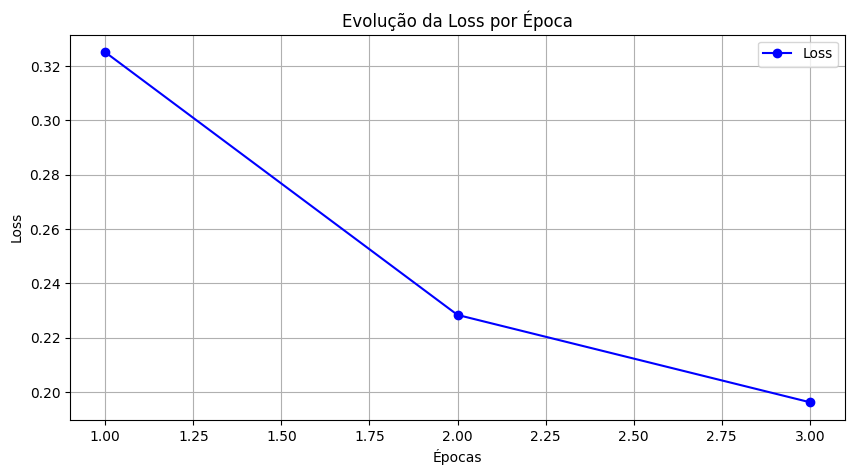

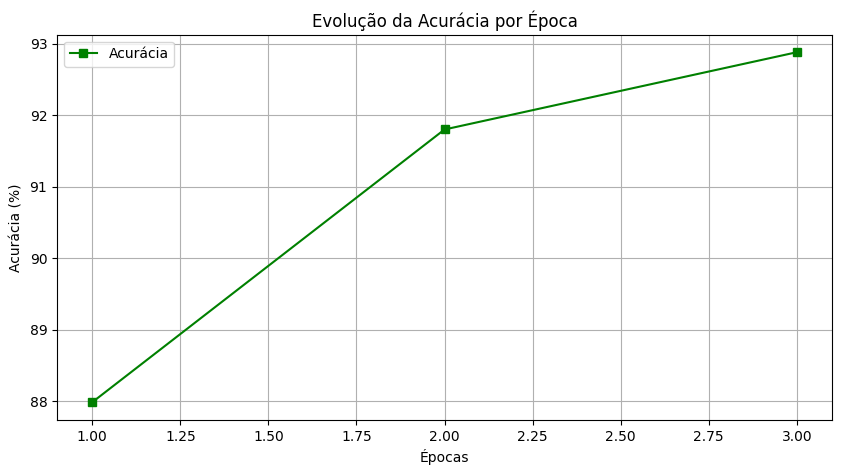

In [ ]:
# Gráfico da evolução da perda (Loss) por época
plt.figure(figsize=(10,5))
plt.plot(epochs_list, loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss por Época')
plt.legend()
plt.grid()
plt.show()

# Gráfico da evolução da acurácia por época
plt.figure(figsize=(10,5))
plt.plot(epochs_list, accuracy_list, marker='s', linestyle='-', color='g', label='Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia (%)')
plt.title('Evolução da Acurácia por Época')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Avaliação do modelo (Validação)
model.eval()             # Coloca o modelo em modo de avaliação
val_loss = 0.0
correct = 0
total = 0
val_losses = []
val_accuracies = []
class_correct = Counter()
class_total = Counter()
class_losses = Counter()
all_preds = []
all_labels = []


# Desabilita gradientes para a fase de validação (economia de memória/cálculo)
with torch.no_grad():
    # Itera sobre os lotes do conjunto de validação
    for images_batch, labels_batch in val_loader:
        # Move para GPU se disponível
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        # Forward
        outputs = model(images_batch)
        # Calcula perda de validação
        loss = criterion(outputs, labels_batch)
        val_loss += loss.item()

        # Calcula acertos
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

        # Armazena previsões e rótulos para métricas detalhadas
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

        # Contabiliza acertos e perdas por classe, para análises de métricas
        for i in range(labels_batch.size(0)):
            label = labels_batch[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == labels_batch[i]:
                class_correct[label] += 1

    # Cálculo de média da perda e acurácia
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.2552, Accuracy: 91.71%



Matriz de Confusão:
[[1094   98    0    5]
 [ 104 1887   15    3]
 [  11    7  259    2]
 [  58   47    3  640]]

Relatório de Classificação:
Lung_Opacity: Precision: 0.86, Recall: 0.91, F1-score: 0.89, Support: 1197.0
Normal: Precision: 0.93, Recall: 0.94, F1-score: 0.93, Support: 2009.0
Viral Pneumonia: Precision: 0.94, Recall: 0.93, F1-score: 0.93, Support: 279.0
COVID: Precision: 0.98, Recall: 0.86, F1-score: 0.92, Support: 748.0
macro avg: Precision: 0.93, Recall: 0.91, F1-score: 0.92, Support: 4233.0
weighted avg: Precision: 0.92, Recall: 0.92, F1-score: 0.92, Support: 4233.0

Acurácia por classe:
Classe Lung_Opacity: Acurácia: 91.40%, Loss: 0.2404
Classe Normal: Acurácia: 93.93%, Loss: 0.2312
Classe COVID: Acurácia: 85.56%, Loss: 0.2411
Classe Viral Pneumonia: Acurácia: 92.83%, Loss: 0.2442


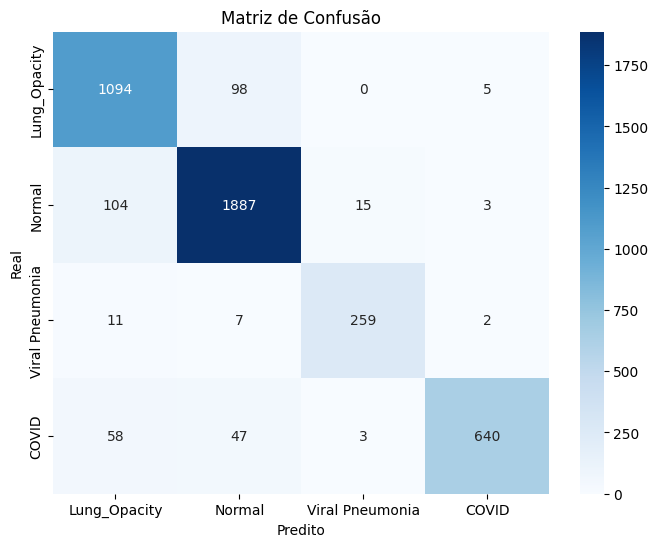

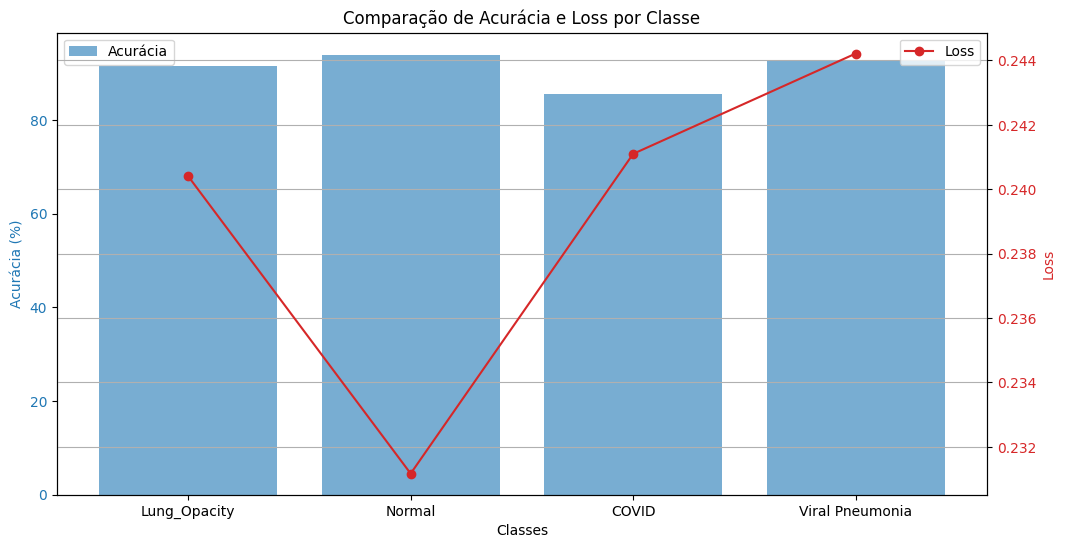

In [ ]:
# Cálculo da Matriz de Confusão e Relatório de Classificação
cm = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(
    all_labels,
    all_preds,
    target_names=class_map.values(),
    output_dict=True
)

# Exibe a Matriz de Confusão
print("\nMatriz de Confusão:")
print(cm)

# Exibe o Relatório de Classificação (precision, recall, f1-score, etc.)
print("\nRelatório de Classificação:")
for class_label, metrics in classification_rep.items():
    # Verifica se o item é um dicionário para imprimir métricas específicas de classe
    if isinstance(metrics, dict):
        print(f"{class_label}: "
              f"Precision: {metrics['precision']:.2f}, "
              f"Recall: {metrics['recall']:.2f}, "
              f"F1-score: {metrics['f1-score']:.2f}, "
              f"Support: {metrics['support']}")

# Calcula a acurácia por classe, bem como a média de perda (Loss) por classe
class_names = [class_map[idx] for idx in class_total.keys()]
class_accuracies = [
    100.0 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0
    for idx in class_total.keys()
]
class_losses_avg = [
    class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0
    for idx in class_total.keys()
]

# Exibe a acurácia por classe
print("\nAcurácia por classe:")
for name, acc, loss_val in zip(class_names, class_accuracies, class_losses_avg):
    print(f"Classe {name}: Acurácia: {acc:.2f}%, Loss: {loss_val:.4f}")

# Plot da Matriz de Confusão com heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_map.values(),
            yticklabels=class_map.values())
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Gráfico comparativo de Acurácia e Loss por Classe
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Classes')
ax1.set_ylabel('Acurácia (%)', color='tab:blue')
# Barra para acurácia
ax1.bar(class_names, class_accuracies, color='tab:blue', alpha=0.6, label='Acurácia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Segundo eixo Y para exibir o Loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
# Linha para o Loss
ax2.plot(class_names, class_losses_avg, marker='o', linestyle='-', color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Comparação de Acurácia e Loss por Classe')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Validation Loss: 0.2552, Accuracy: 91.71%

Matriz de Confusão:
[[1965   37    1    1]
 [ 192  989    0   12]
 [  28    3  229    5]
 [  56   15    1  699]]

Relatório de Classificação:
Normal: Precision: 0.88, Recall: 0.98, F1-score: 0.93, Suporte: 2004.0
Lung_Opacity: Precision: 0.95, Recall: 0.83, F1-score: 0.88, Suporte: 1193.0
Viral Pneumonia: Precision: 0.99, Recall: 0.86, F1-score: 0.92, Suporte: 265.0
COVID: Precision: 0.97, Recall: 0.91, F1-score: 0.94, Suporte: 771.0
macro avg: Precision: 0.95, Recall: 0.90, F1-score: 0.92, Suporte: 4233.0
weighted avg: Precision: 0.92, Recall: 0.92, F1-score: 0.92, Suporte: 4233.0

Acurácia por classe:
Classe Normal: Acurácia: 98.05%, Loss: 0.2481
Classe Lung_Opacity: Acurácia: 82.90%, Loss: 0.2665
Classe Viral Pneumonia: Acurácia: 86.42%, Loss: 0.2664
Classe COVID: Acurácia: 90.66%, Loss: 0.2596


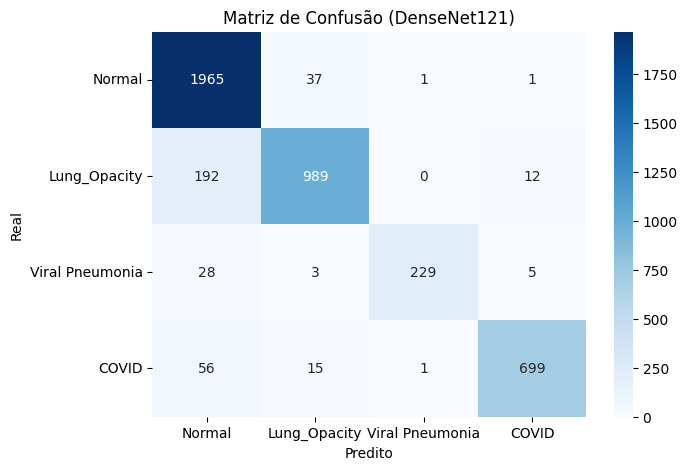


✅ Conformal Prediction Manual:
Cobertura (acerto): 0.93 (com 95% de confiança)
Tamanho médio do conjunto predito: 1.05


In [ ]:
##################################
# (6) VALIDAÇÃO + COLETA DE PROBS
##################################
import torch.nn.functional as F

model.eval()
val_loss = 0.0
correct = 0
total = 0

from collections import defaultdict
class_correct = defaultdict(int)
class_total = defaultdict(int)
class_losses = defaultdict(float)

all_preds = []
all_labels = []
all_probs = []  # <- Para armazenar probabilidades (softmax)

with torch.no_grad():
    for images_batch, labels_batch in val_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        val_loss += loss.item()

        # Calcula probabilidades via softmax
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())  # Armazena p/ Conformal

        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

        # Armazena predições e rótulos
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

        # Cálculo de acurácia e perda por classe
        for i in range(labels_batch.size(0)):
            label = labels_batch[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == label:
                class_correct[label] += 1

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100.0 * correct / total

print(f"\nValidation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# Matriz de Confusão
cm = confusion_matrix(all_labels, all_preds)
print("\nMatriz de Confusão:")
print(cm)

# Relatório de Classificação
class_names_list = [class_map[idx] for idx in sorted(class_map.keys())]
classification_rep = classification_report(
    all_labels,
    all_preds,
    target_names=class_names_list,
    output_dict=True
)

print("\nRelatório de Classificação:")
for class_label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        print(f"{class_label}: "
              f"Precision: {metrics['precision']:.2f}, "
              f"Recall: {metrics['recall']:.2f}, "
              f"F1-score: {metrics['f1-score']:.2f}, "
              f"Suporte: {metrics['support']}")

# Acurácia e Loss por classe
print("\nAcurácia por classe:")
for idx in sorted(class_total.keys()):
    acc = 100.0 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0
    loss_val = class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0
    print(f"Classe {class_map[idx]}: Acurácia: {acc:.2f}%, Loss: {loss_val:.4f}")

# Plot da Matriz de Confusão
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_list,
            yticklabels=class_names_list)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (DenseNet121)")
plt.show()

#############################################
# (7) PREDIÇÃO CONFORMAL MANUAL (SEM MAPIE)
#############################################
import numpy as np
from sklearn.model_selection import train_test_split

# Convertendo lista de probabilidades e labels para array NumPy
probs_np = np.array(all_probs)   # shape: (N, num_classes)
labels_np = np.array(all_labels) # shape: (N,)

# Separa ~20% do VAL para calibração
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    probs_np, labels_np, test_size=0.2, random_state=42
)

# 1) Não conformidade no conjunto de calibração = 1 - probabilidade da classe correta
nonconformity_scores = []
for i in range(len(X_calib)):
    prob = X_calib[i]         # ex: [0.1, 0.7, 0.2, ...]
    true_label = y_calib[i]   # índice da classe correta
    score = 1.0 - prob[true_label]
    nonconformity_scores.append(score)

nonconformity_scores = np.array(nonconformity_scores)
nonconformity_scores_sorted = np.sort(nonconformity_scores)

# 2) Define nível de confiança (ex: alpha=0.05 -> 95% de confiança)
alpha = 0.05
q_hat = np.quantile(nonconformity_scores_sorted, 1 - alpha)

# 3) Gerar conjuntos preditos (prediction sets) para o resto da validação
prediction_sets = []
correct_in_set = 0

for i in range(len(X_val_conf)):
    prob = X_val_conf[i]
    # Classes cuja não conformidade (1 - prob[j]) <= q_hat
    pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]
    prediction_sets.append(pred_set)

    # Verifica se a classe real está no conjunto
    if y_val_conf[i] in pred_set:
        correct_in_set += 1

coverage = correct_in_set / len(X_val_conf)
avg_set_size = np.mean([len(ps) for ps in prediction_sets])

print("\n✅ Conformal Prediction Manual:")
print(f"Cobertura (acerto): {coverage:.2f} (com 95% de confiança)")
print(f"Tamanho médio do conjunto predito: {avg_set_size:.2f}")

# Exemplo adicional: Você pode repetir para outros valores de alpha,
# para ver como muda a cobertura e o tamanho do conjunto predito.

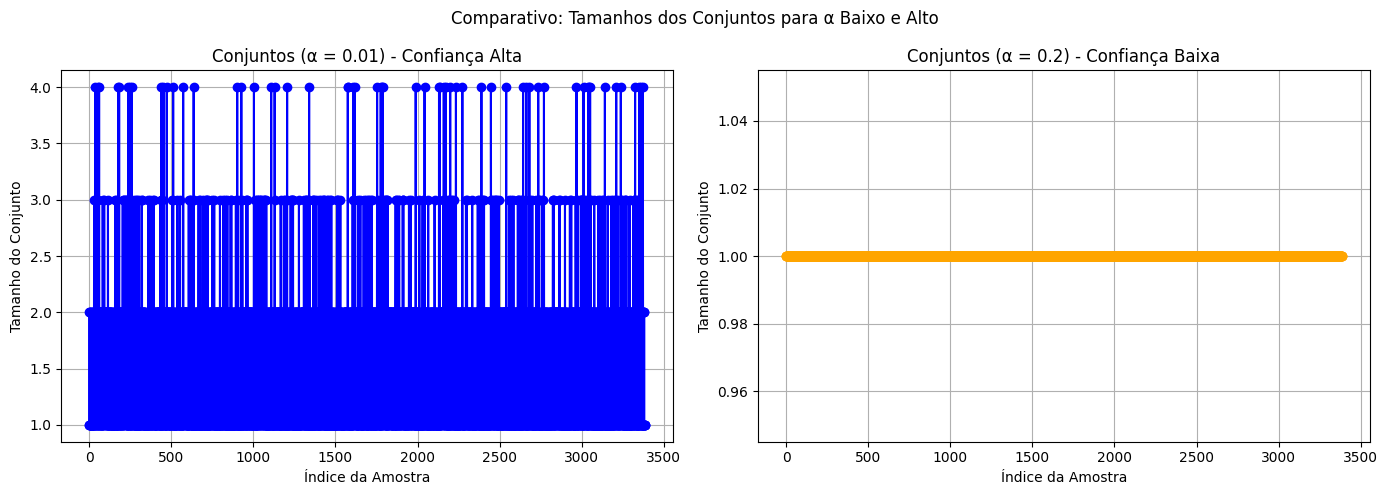


📋 Tabela: Frequência dos Tamanhos (Confiança Alta - α = 0.01)
 Tamanho do Conjunto (α = 0.01)  Quantidade
                              1        1825
                              2        1292
                              3         211
                              4          58

📋 Tabela: Frequência dos Tamanhos (Confiança Baixa - α = 0.20)
 Tamanho do Conjunto (α = 0.20)  Quantidade
                              1        3386


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Supondo que all_probs e all_labels já tenham sido definidos durante a validação
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    np.array(all_probs), np.array(all_labels), test_size=0.2, random_state=42
)

# Função para gerar conjuntos de predição

def generate_prediction_sets(X_probs, y_true, nonconformity_scores, alpha):
    q_hat = np.quantile(nonconformity_scores, 1 - alpha)
    prediction_sets = []
    correct_in_set = 0

    for i in range(len(X_probs)):
        prob = X_probs[i]
        pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]

        # Correção: se conjunto estiver vazio, incluir a classe de maior probabilidade
        if len(pred_set) == 0:
            pred_set = [int(np.argmax(prob))]

        prediction_sets.append(pred_set)
        if y_true[i] in pred_set:
            correct_in_set += 1

    coverage = correct_in_set / len(X_probs)
    avg_size = np.mean([len(s) for s in prediction_sets])
    return prediction_sets, coverage, avg_size

# Etapa 1: calcular não conformidade para calibração
nonconformity_scores = [1 - X_calib[i][y_calib[i]] for i in range(len(X_calib))]

# Testar alpha menos permissivo (maior confiança)
alpha_low = 0.01
sets_low, cov_low, avg_low = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_low)
set_sizes_low = [len(s) for s in sets_low]

# Testar alpha mais permissivo (menor confiança)
alpha_high = 0.20
sets_high, cov_high, avg_high = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_high)
set_sizes_high = [len(s) for s in sets_high]

# Gráficos
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(range(len(set_sizes_low)), set_sizes_low, marker='o', linestyle='-', color='blue')
axs[0].set_title(f"Conjuntos (α = {alpha_low}) - Confiança Alta")
axs[0].set_xlabel("Índice da Amostra")
axs[0].set_ylabel("Tamanho do Conjunto")
axs[0].grid(True)

axs[1].plot(range(len(set_sizes_high)), set_sizes_high, marker='o', linestyle='-', color='orange')
axs[1].set_title(f"Conjuntos (α = {alpha_high}) - Confiança Baixa")
axs[1].set_xlabel("Índice da Amostra")
axs[1].set_ylabel("Tamanho do Conjunto")
axs[1].grid(True)

plt.suptitle("Comparativo: Tamanhos dos Conjuntos para α Baixo e Alto")
plt.tight_layout()
plt.show()

# Tabelas comparativas
unique_low, count_low = np.unique(set_sizes_low, return_counts=True)
df_low = pd.DataFrame({
    "Tamanho do Conjunto (α = 0.01)": unique_low,
    "Quantidade": count_low
})

unique_high, count_high = np.unique(set_sizes_high, return_counts=True)
df_high = pd.DataFrame({
    "Tamanho do Conjunto (α = 0.20)": unique_high,
    "Quantidade": count_high
})

print("\n📋 Tabela: Frequência dos Tamanhos (Confiança Alta - α = 0.01)")
print(df_low.to_string(index=False))

print("\n📋 Tabela: Frequência dos Tamanhos (Confiança Baixa - α = 0.20)")
print(df_high.to_string(index=False))


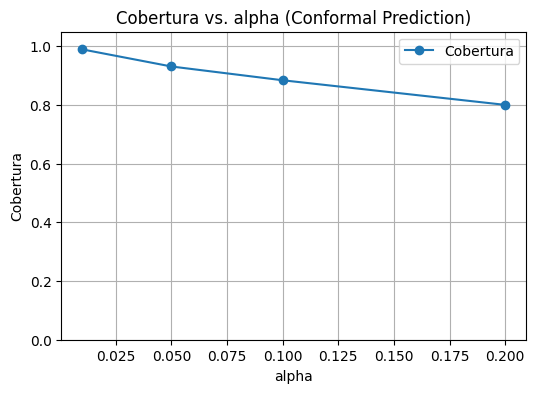

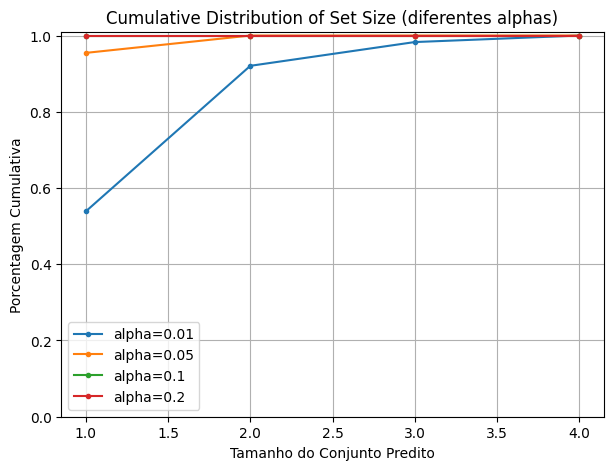

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Supomos que você JÁ possua:
# X_calib, y_calib, X_val_conf, y_val_conf
# onde:
# - X_calib: probabilidades softmax do conjunto de calibração
# - y_calib: rótulos corretos do conjunto de calibração
# - X_val_conf: probabilidades softmax do conjunto de validação (exceto calibração)
# - y_val_conf: rótulos corretos do conjunto de validação
# -------------------------------------------------

def compute_prediction_sets(probs_val, q_hat):
    """
    Retorna a lista de conjuntos preditos, onde cada conjunto
    contém as classes j cujo (1 - prob[j]) <= q_hat.
    """
    prediction_sets = []
    for prob in probs_val:
        pred_set = [j for j in range(len(prob)) if (1.0 - prob[j]) <= q_hat]
        prediction_sets.append(pred_set)
    return prediction_sets

def coverage_and_size(prediction_sets, true_labels):
    """
    Calcula a cobertura (percentual de vezes em que o rótulo verdadeiro
    está no conjunto) e o tamanho médio dos conjuntos.
    """
    correct_in_set = 0
    for pset, true_label in zip(prediction_sets, true_labels):
        if true_label in pset:
            correct_in_set += 1
    coverage = correct_in_set / len(true_labels)
    avg_size = np.mean([len(pset) for pset in prediction_sets])
    return coverage, avg_size

# 1) Calcular não conformidade no conjunto de calibração (1 - prob da classe correta)
scores_calib = 1.0 - np.array([X_calib[i, y_calib[i]] for i in range(len(X_calib))])
scores_calib_sorted = np.sort(scores_calib)

# 2) Escolher múltiplos valores de alpha para ver o efeito
alpha_values = [0.01, 0.05, 0.1, 0.2]  # Exemplo
coverages = []
avg_sizes = []

# Para plot de Cumulative Distribution of Set Size
cdf_data = {}  # dict alpha -> array com tamanhos

N_val = len(X_val_conf)  # número de amostras na parte de validação

for alpha in alpha_values:
    # Determinar o quantil q_hat
    q_hat = np.quantile(scores_calib_sorted, 1 - alpha)

    # Formar conjuntos preditos
    prediction_sets = compute_prediction_sets(X_val_conf, q_hat)

    # Cobertura e tamanho médio
    coverage, avg_size = coverage_and_size(prediction_sets, y_val_conf)
    coverages.append(coverage)
    avg_sizes.append(avg_size)

    # Vamos também guardar o tamanho de cada conjunto predito para plot de distribuição
    set_sizes = [len(ps) for ps in prediction_sets]
    cdf_data[alpha] = np.array(set_sizes)

####################################
# Plot 1: Coverage vs. alpha
####################################
plt.figure(figsize=(6,4))
plt.plot(alpha_values, coverages, marker='o', label='Cobertura')
plt.xlabel('alpha')
plt.ylabel('Cobertura')
plt.title('Cobertura vs. alpha (Conformal Prediction)')
plt.ylim([0, 1.05])
plt.grid()
plt.legend()
plt.show()

####################################
# Plot 2: Cumulative Distribution of Set Size
####################################
# Aqui, para cada alpha, calculamos a porcentagem cumulativa
# de exemplos que têm conjunto predito de tamanho <= k.

max_set_size = 0
for alpha in alpha_values:
    max_size_alpha = cdf_data[alpha].max()
    if max_size_alpha > max_set_size:
        max_set_size = max_size_alpha

# Vamos criar valores de x (tamanho do conjunto) de 1 até max_set_size.
x_vals = np.arange(1, max_set_size + 1)

plt.figure(figsize=(7,5))
for alpha in alpha_values:
    sizes = cdf_data[alpha]
    cdf = [(sizes <= k).mean() for k in x_vals]
    plt.plot(x_vals, cdf, marker='.', linestyle='-', label=f'alpha={alpha}')

plt.xlabel('Tamanho do Conjunto Predito')
plt.ylabel('Porcentagem Cumulativa')
plt.title('Cumulative Distribution of Set Size (diferentes alphas)')
plt.ylim([0,1.01])
plt.grid()
plt.legend()
plt.show()
